In [1]:
import os
import zipfile
from PIL import Image
import numpy as np
import json

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import Callback

from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
def preprocess(path1, path2, label):
    ELA_images = []
    SRM_images = []
    labels = []

    prefix = 'Real' if label == 0 else 'Fake'
    ela_root = os.path.join(path1, prefix)
    srm_root = os.path.join(path2, prefix)

    folders = sorted(os.listdir(ela_root))
    cnt_folders = 0
    total_images = 0
    for folder in folders:
        ela_folder_path = os.path.join(ela_root, folder)
        srm_folder_path = os.path.join(srm_root, folder)

        if not os.path.exists(srm_folder_path):
            continue

        ela_files = sorted(os.listdir(ela_folder_path))
        srm_files = sorted(os.listdir(srm_folder_path))
        cnt_images = 0
        for ela_file, srm_file in zip(ela_files, srm_files):
            ela_path = os.path.join(ela_folder_path, ela_file)
            srm_path = os.path.join(srm_folder_path, srm_file)


            try:
                ela_img = Image.open(ela_path).convert('RGB').resize((128, 128))
                srm_img = Image.open(srm_path).convert('RGB').resize((128, 128))

                ELA_images.append(np.array(ela_img))
                SRM_images.append(np.array(srm_img))
                labels.append(label)
                cnt_images += 1
                total_images += 1
                if total_images >= 80000 or cnt_images == 140:
                    break

            except Exception as e:
                print(f"Skipping image pair ({ela_file}, {srm_file}): {e}")
        cnt_folders += 1
        if total_images >= 80000:
            print(total_images)
            break
    print(f'No of Folders taken: {cnt_folders}')
        
    return ELA_images, SRM_images, labels

In [4]:
# Paths to your dataset folders
path1 = '../../Data/Celeb DF/ELA'      # Path of the ELA root folder of a Dataset
path2 = '../../Data/Celeb DF/SRM'      # Path of the SRM root folder of a Dataset

# Load and preprocess both classes
ela_real, srm_real, labels_real = preprocess(path1, path2, label=0)
ela_fake, srm_fake, labels_fake = preprocess(path1, path2, label=1)

# Merge data without using np.concatenate (faster and lower memory)
ELA_total = np.array(ela_real + ela_fake, dtype=np.float32) / 255.0
SRM_total = np.array(srm_real + srm_fake, dtype=np.float32) / 255.0
labels_total = np.array(labels_real + labels_fake)

print(f"Loaded {len(labels_total)} samples.")
print(f"ELA shape: {ELA_total.shape}, dtype: {ELA_total.dtype}")
print(f"SRM shape: {SRM_total.shape}, dtype: {SRM_total.dtype}")

80000
No of Folders taken: 575
80000
No of Folders taken: 573
Loaded 160000 samples.
ELA shape: (160000, 128, 128, 3), dtype: float32
SRM shape: (160000, 128, 128, 3), dtype: float32


In [5]:
def build_model(input_shape=(128, 128, 3)):
    """Your model architecture"""
    # ELA Branch
    input_ela = layers.Input(shape=input_shape, name='ELA_Input')
    x_ela = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_ela)
    x_ela = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x_ela)
    x_ela = layers.MaxPooling2D((2, 2))(x_ela)
    x_ela = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x_ela)
    x_ela = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x_ela)
    x_ela = layers.MaxPooling2D((2, 2))(x_ela)

    # SRM Branch
    input_srm = layers.Input(shape=input_shape, name='SRM_Input')
    x_srm = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_srm)
    x_srm = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x_srm)
    x_srm = layers.MaxPooling2D((2, 2))(x_srm)
    x_srm = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x_srm)
    x_srm = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x_srm)
    x_srm = layers.MaxPooling2D((2, 2))(x_srm)

    # Concatenate the outputs of both branches
    combined = layers.Concatenate()([x_ela, x_srm])
    combined = layers.Dropout(0.25)(combined)
    combined = layers.Flatten()(combined)

    # Fully connected layers
    fc = layers.Dense(256, activation='relu')(combined)
    fc = layers.Dropout(0.5)(fc)
    output = layers.Dense(1, activation='sigmoid')(fc)

    # Create the model
    model = models.Model(inputs=[input_ela, input_srm], outputs=output)

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [6]:
ELA_train, ELA_test, SRM_train, SRM_test, y_train, y_test = train_test_split(
        ELA_total, SRM_total, labels_total, test_size=0.2, random_state=42)
del ELA_total , SRM_total ,labels_total
print(f'ELA train shape is: {ELA_train.shape}')
print(f'SRM train shape is: {SRM_train.shape}')

ELA train shape is: (128000, 128, 128, 3)
SRM train shape is: (128000, 128, 128, 3)


In [7]:
model = build_model()

2025-06-26 11:12:53.670991: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2025-06-26 11:12:54.483002: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.73GiB deviceMemoryBandwidth: 298.08GiB/s
2025-06-26 11:12:54.483863: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 1 with properties: 
pciBusID: 0000:d8:00.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.73GiB deviceMemoryBandwidth: 298.08GiB/s
2025-06-26 11:12:54.516694: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2025-06-26 11:12:54.621286: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-06-26 11:12:54.6

In [8]:
class MinDiffCheckpoint(Callback):
    def __init__(self, filepath, monitor='val_accuracy', prev_val = -10**9 ,min_delta=0.02):
        super(MinDiffCheckpoint, self).__init__()
        self.filepath = filepath
        self.monitor = monitor
        self.min_delta = min_delta       # Minimum acceptable difference
        self.best_diff = np.inf          # Initialize with infinity
        self.best_weights = None
        self.prev_val = prev_val
        
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        
        # Get current metrics
        val_acc = logs.get('val_accuracy')
        train_acc = logs.get('accuracy')
        
        if val_acc is None or train_acc is None:
            return
            
        # Calculate absolute difference
        current_diff = abs(train_acc - val_acc)
        
        # Check if difference is below threshold and better than previous best
        if current_diff < self.min_delta or current_diff < self.best_diff:
            
            # Save the model
            if self.prev_val < val_acc:
                self.prev_val=val_acc
                self.model.save_weights(self.filepath, overwrite=True)
                print(f"\nDifference improved from {self.best_diff:.4f} to {current_diff:.4f}")
                self.best_diff = current_diff
                self.best_weights = self.model.get_weights()
                print(f"Model saved with train-val difference: {current_diff:.4f}")

    def on_train_end(self, logs=None):
        # Restore the best weights found
        if self.best_weights is not None:
            self.model.set_weights(self.best_weights)
            print(f"\nTraining complete. Restoring weights with best difference: {self.best_diff:.4f}")
            

In [9]:
checkpoint = MinDiffCheckpoint(
    filepath='checkPoint_CDF.keras',        # Name of saved checkpoint
    monitor='val_accuracy',
    min_delta=0.1
)


In [11]:
history = model.fit(
        [ELA_train, SRM_train],
        y_train,
        epochs=20,
        batch_size=32,
        validation_data = ([ELA_test, SRM_test], y_test),
        callbacks = [checkpoint]
    )


2025-06-26 11:12:58.935186: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 25165824000 exceeds 10% of free system memory.
2025-06-26 11:13:08.766562: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 25165824000 exceeds 10% of free system memory.


Epoch 1/20


2025-06-26 11:13:19.268265: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-06-26 11:13:19.952334: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


4000/4000 [==============================] - ETA: 0s - loss: 0.2628 - accuracy: 0.8891
Difference improved from inf to 0.0741
Model saved with train-val difference: 0.0741
4000/4000 [==============================] - 255s 64ms/step - loss: 0.2628 - accuracy: 0.8891 - val_loss: 0.1082 - val_accuracy: 0.9632
Epoch 2/20
4000/4000 [==============================] - ETA: 0s - loss: 0.0930 - accuracy: 0.9661
Difference improved from 0.0741 to 0.0164
Model saved with train-val difference: 0.0164
4000/4000 [==============================] - 261s 65ms/step - loss: 0.0930 - accuracy: 0.9661 - val_loss: 0.0529 - val_accuracy: 0.9824
Epoch 3/20
4000/4000 [==============================] - ETA: 0s - loss: 0.0529 - accuracy: 0.9815
Difference improved from 0.0164 to 0.0076
Model saved with train-val difference: 0.0076
4000/4000 [==============================] - 261s 65ms/step - loss: 0.0529 - accuracy: 0.9815 - val_loss: 0.0318 - val_accuracy: 0.9891
Epoch 4/20
4000/4000 [==========================

In [12]:
model.save('Celeb_DF.keras')     # Saving of the model with best metrics

In [14]:
model = tf.keras.models.load_model('Celeb_DF.keras')
y_pred_prob = model.predict([ELA_test, SRM_test])
y_pred = (y_pred_prob > 0.5).astype(int).flatten()


Accuracy: 0.99728125


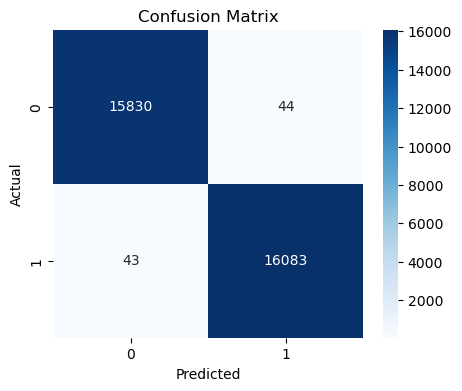

In [16]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

print("Accuracy:", acc)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


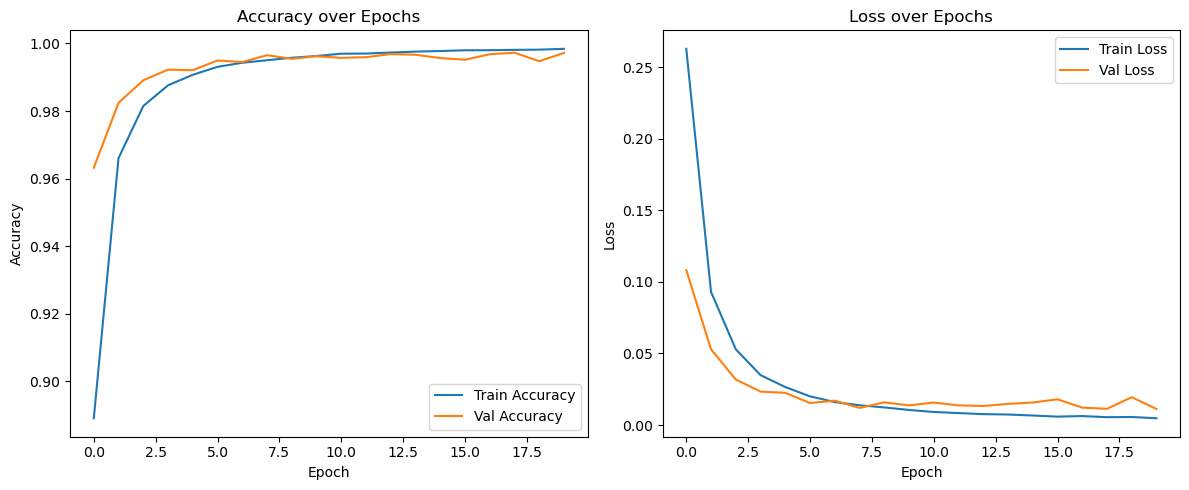

In [17]:
# Accuracy plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

0.9999070860347573


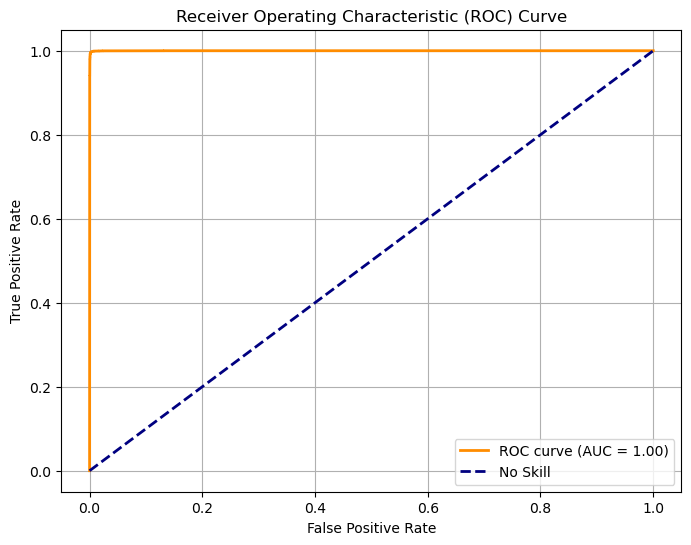

In [18]:
# AUC-ROC Curve
y_probs = model.predict([ELA_test, SRM_test])

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
print(roc_auc_score(y_test, y_probs))
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()